In [1]:
from Tokenize_Vectorize import *
from keras.models import Sequential
from keras.layers import Dense, Conv1D, GlobalMaxPooling1D
from keras.layers import Dropout
from keras.layers import Activation
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt

word_vectors = KeyedVectors.load_word2vec_format('cc.it.300.vec')

Using TensorFlow backend.


Cleaning...
Calculating TFIDF...
Calculating SVD...
Calculating LDiA...


In [2]:
def vectorize(tokens):
    vectorized_data = []
    sample_vecs = []
    for sample in tokens:
        for token in sample:
            try:
                sample_vecs.append(word_vectors[token])
            except KeyError:
                pass # No matching token in the fasttext vocab
        vectorized_data.append(sample_vecs)

    return vectorized_data


In [3]:
def pad_trunc(data, maxlen):
    
    new_data = []
    # Create a vector of 0s the length of our word vectors
    zero_vector = []
    for _ in range(len(data[0][0])):
        zero_vector.append(0.0)
    for sample in data:
        if len(sample) > maxlen:
            temp = sample[:maxlen]
        elif len(sample) < maxlen:
            temp = sample
            # Append the appropriate number 0 vectors to the list
            additional_elems = maxlen - len(sample)
            for _ in range(additional_elems):
                temp.append(zero_vector)
        else:
            temp = sample
        new_data.append(temp)
    return new_data

In [4]:

x_train = vectorize(tokenized)
y_train = dummy_y
x_test = vectorize(tokenized_dev)
y_test = dummy_dev

In [55]:
x_train[0][0]

array([ 0.0606, -0.0176,  0.0957, -0.0315, -0.0288, -0.059 ,  0.052 ,
        0.0059, -0.1145,  0.0741, -0.0065, -0.0155,  0.0218,  0.0152,
        0.0383,  0.0045, -0.0127,  0.1433,  0.0484, -0.0326,  0.022 ,
       -0.0346, -0.0122, -0.0189, -0.0069,  0.0844, -0.064 ,  0.0299,
        0.0332, -0.0406,  0.0857, -0.1177,  0.0034, -0.0337, -0.0548,
        0.0268,  0.0368, -0.0227, -0.0343,  0.0584, -0.0228, -0.0358,
       -0.0231,  0.039 ,  0.0063,  0.1312, -0.0449, -0.0143,  0.0042,
        0.1289,  0.0598,  0.0108,  0.0249,  0.0308,  0.0724, -0.0297,
       -0.0224,  0.0369, -0.0834, -0.0042,  0.0099, -0.1038, -0.1418,
       -0.0095, -0.0199,  0.0309, -0.0142,  0.0304,  0.0129, -0.0562,
       -0.016 , -0.0455,  0.008 , -0.056 , -0.0142, -0.0683,  0.0698,
       -0.0388,  0.0123, -0.0283,  0.0162,  0.045 , -0.0877,  0.1062,
       -0.0154,  0.1369, -0.0416, -0.0101, -0.0129,  0.0028, -0.0289,
        0.0043, -0.0905,  0.046 , -0.1417, -0.0523, -0.0448, -0.054 ,
       -0.0447, -0.0

In [87]:
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import MaxPooling1D
max_len = 18        # maximum length of the text (why?)
batch_size = 8       # number of samples before backpropagating
embedding_dims = 300  # Same as Google's
filters = 5         # (!)
kernel_size = 3       # remember: filter=kernel (we have a scalar this time)
hidden_dims = 16     # number of neurons in the final layer
epochs = 2            # number of training epochs

In [74]:
x_train = pad_trunc(x_train, max_len)
x_test = pad_trunc(x_test, max_len)
x_train = np.reshape(x_train, (len(x_train), max_len, embedding_dims))
y_train = np.array(y_train)
x_test = np.reshape(x_test, (len(x_test), max_len, embedding_dims))
y_test = np.array(y_test)

In [88]:
acc_per_fold = []
loss_per_fold = []
reports = []
cf_matrices = []

num_folds = 10
kfold = KFold(n_splits=10)
inputs = np.concatenate((x_train, x_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)
# K-fol Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
    model = Sequential() # The standard NN model
    model.add(Conv1D(  # Adding a convolutional layer
    filters,
    kernel_size,
    padding='valid',  # in this example the output is going to be lightly smaller
    activation='relu',
    strides=1,  # the shift
    input_shape=(max_len, embedding_dims))
    )
    model.add(GlobalMaxPooling1D())
    model.add(Dense(hidden_dims))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Dense(6, activation="softmax"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    model.fit(inputs[train], targets[train], epochs=epochs, batch_size=batch_size, verbose=0, class_weight=class_weight)

    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1] * 100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    Y = np.argmax(targets[test], axis=1)  # here we build the precision/recall/f1 table for each fold
    y_pred = model.predict_classes(inputs[test])
    reports.append(classification_report(Y, y_pred, output_dict=True))
    cm = confusion_matrix(Y, y_pred)
    cm = cm / cm.astype(np.float).sum(axis=1)
    cf_matrices.append(cm.round(2))
    # Increase fold number
    fold_no += 1

            # == Provide average scores ==
print('------------------------------------------------------------------------')

print('Score per fold')
f1_report = []
for n in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {n + 1} - Loss: {loss_per_fold[n]} - Accuracy: {acc_per_fold[n]}%')
    print('------------------------------------------------------------------------')
    print(f'> Per Class Report:\n{reports[n]}')
    f1_report.append(reports[n]['weighted avg']['f1-score'])
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> F1-Score: {np.mean(f1_report).round(3)} (+-{np.std(f1_report).round(3)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print(f'> Confusion Matrix:\n{np.nanmean(cf_matrices, axis=0)}')
print('------------------------------------------------------------------------')
'''model_structure = model.to_json()
with open(f"NN_tfidf_{i}.json", "w") as json_file:
    json_file.write(model_structure)  # saves just the architecture
model.save_weights(f"Weights_tfidf_{i}")  # saves the weights
'''


------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 1.7900481479897348; accuracy of 21.004566550254822%
------------------------------------------------------------------------
Training for fold 2 ...


c:\users\daimon\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Score for fold 2: loss of 1.7875595497428824; accuracy of 19.7247713804245%
------------------------------------------------------------------------
Training for fold 3 ...


c:\users\daimon\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Score for fold 3: loss of 1.787899940385731; accuracy of 19.7247713804245%
------------------------------------------------------------------------
Training for fold 4 ...


c:\users\daimon\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Score for fold 4: loss of 1.8081316816697426; accuracy of 12.844036519527435%
------------------------------------------------------------------------
Training for fold 5 ...


c:\users\daimon\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Score for fold 5: loss of 1.7893533422312606; accuracy of 14.678898453712463%
------------------------------------------------------------------------
Training for fold 6 ...


c:\users\daimon\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Score for fold 6: loss of 1.7904555272618565; accuracy of 13.302752375602722%
------------------------------------------------------------------------
Training for fold 7 ...


c:\users\daimon\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Score for fold 7: loss of 1.7858719924174318; accuracy of 14.220184087753296%
------------------------------------------------------------------------
Training for fold 8 ...


c:\users\daimon\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Score for fold 8: loss of 1.7895041682304593; accuracy of 18.807339668273926%
------------------------------------------------------------------------
Training for fold 9 ...


c:\users\daimon\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Score for fold 9: loss of 1.7823806071500166; accuracy of 13.761468231678009%
------------------------------------------------------------------------
Training for fold 10 ...


c:\users\daimon\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Score for fold 10: loss of 1.7657108350631294; accuracy of 33.48623812198639%
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.7900481479897348 - Accuracy: 21.004566550254822%
------------------------------------------------------------------------
> Per Class Report:
{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 33}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 37}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 28}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 19}, '4': {'precision': 0.2100456621004566, 'recall': 1.0, 'f1-score': 0.3471698113207547, 'support': 46}, '5': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 56}, 'accuracy': 0.2100456621004566, 'macro avg': {'precision': 0.0350076103500761, 'recall': 0.16666666666666666, 'f1-score': 0.0578616352201

c:\users\daimon\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'model_structure = model.to_json()\nwith open(f"NN_tfidf_{i}.json", "w") as json_file:\n    json_file.write(model_structure)  # saves just the architecture\nmodel.save_weights(f"Weights_tfidf_{i}")  # saves the weights\n'

In [ ]:
print('Building model...')

model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(6, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), verbose=1)

Test loss: 1.7132862912498505 / Test accuracy: 0.24696356058120728
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


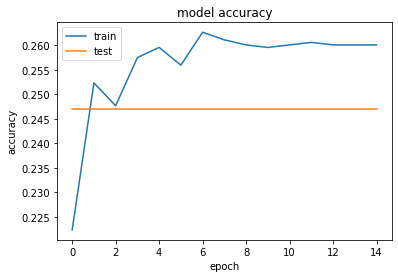

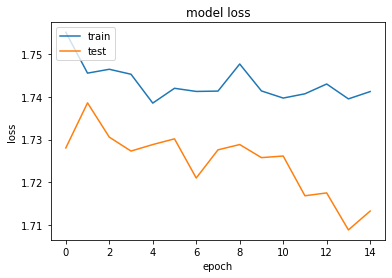

In [62]:

score = model.evaluate(x_test, y_test, verbose=0)

print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



In [65]:
from keras.layers import Flatten, SimpleRNN
num_neurons = 50

In [66]:
model1 = Sequential()
model1.add(SimpleRNN(
    num_neurons, 
    return_sequences=True,
    input_shape=(max_len, embedding_dims))
     )
model1.add(Dropout(.2))
model1.add(Flatten())
model1.add(Dense(6, activation='sigmoid'))
model1.compile('rmsprop', 
              'categorical_crossentropy', 
              metrics=['accuracy'])
model1.summary()
history1 = model1.fit(x_train, 
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
     )
# Flatten??? back to the slides

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 20, 50)            17550     
_________________________________________________________________
dropout_25 (Dropout)         (None, 20, 50)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 6)                 6006      
Total params: 23,556
Trainable params: 23,556
Non-trainable params: 0
_________________________________________________________________
Train on 1934 samples, validate on 247 samples
Epoch 1/15
1934/1934 [==============================] - 1s 288us/step - loss: 1.7603 - accuracy: 0.2497 - val_loss: 1.7641 - val_accuracy: 0.2470
Epoch 2/15
1934/1934 [==============================] 

Test loss: 1.773940162620081 / Test accuracy: 0.24696356058120728
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


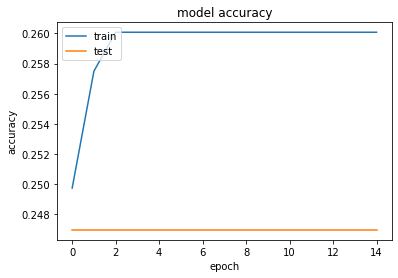

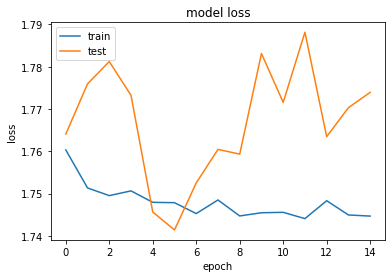

In [67]:

score1 = model1.evaluate(x_test, y_test, verbose=0)

print(f'Test loss: {score1[0]} / Test accuracy: {score1[1]}')

print(history1.history.keys())

# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()